# Create Target Files

This notebook loads DHS survey data and computes aggregated mean statistics for each cluster and stores that data in a `targets.json` file for the specified AOI. Geographic plots are also produced to visualie the cluster level statistics. Variograms of the survey metrics are also produced.

This notebook make use of lower level code in `gist_utils`.


## Input

DHS data is used as the basis for creating partition maps for each country based on the location of clusters. 

<pre style="font-family: monospace;">
./GIS-Image-Stack-Processing
    /DHS
        /County specific folders containing DHS files
</pre>

## Output
<pre style="font-family: monospace;">
./GIS-Image-Stack-Processing
    /AOI/
        PK/
            Targets/
                <span style="color: blue;">targets.json</span> 
        TD/
             Targets/
                <span style="color: blue;">targets.json</span> 

</pre>

## Required Configurations

<pre style="font-family: monospace;">
<span style="color: blue;">country_code  = 'PK'</span>      # Set the country code
</pre>

In [192]:
#-------------------------------------------------
# REQUIRED CONFIGURATIONS HERE
#-------------------------------------------------
country_code  = 'PK'      # Set the country code
#-------------------------------------------------

CREATE_TARGETS = True
CREATE_DHS_MAPS = False

cluster_colors = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'olive', 'teal', 'navy']
symbol_size = 8

In [193]:
import os
import sys
import json
import tempfile
from enum import Enum

import pandas as pd
import geopandas as gpd
import pyreadstat

from bokeh.palettes import Viridis256

from dataclasses import dataclass

from selenium import webdriver
from io import BytesIO
from PIL import Image

# from skgstat import Variogram
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [194]:
sys.path.append('./GIS-Image-Stack-Processing') 
# Import module that contains several convenience functions (e.g., gdal wrappers)
from project_utils import *
from project_utils.aoi_configurations import aoi_configurations
from project_utils.plot_utils import *

## Dataset and Results Configuration

In [195]:
# Enumerated list of DHS target values
@dataclass(frozen=True)
class TargetType(Enum):
    FRACTION_DPT3_VACCINATED  = "fraction_dpt3_vaccinated"
    FRACTION_WITH_ELECTRICITY = "fraction_with_electricity"
    FRACTION_WITH_FRESH_WATER = "fraction_with_fresh_water"
    MEAN_WEALTH_INDEX         = "mean_wealth_index"
    FRACTION_WITH_RADIO       = 'fraction_with_radio'
    FRACTION_WITH_TV          = "fraction_with_tv"

# Result configurations
@dataclass(frozen=True)
class ResultsConfig:
    COMPUTE_GEOSPATIAL: bool = False
    PLOT_GEOSPATIAL_DIR: str = './Plots_Geospatial'
    PLOT_VARIOGRAM_DIR:  str = './Plots_Variograms'

In [196]:
GIS_ROOT = './GIS-Image-Stack-Processing'
PRT_ROOT = './GIS-Image-Stack-Processing/AOI/Partitions'

target_json_path = os.path.join(GIS_ROOT, f'AOI/{country_code}/Targets/targets.json')

results_config = ResultsConfig()

## DHS Data Configuration

In [197]:
shapefile_path = os.path.join(GIS_ROOT, aoi_configurations[country_code]['shapefile'])
recode_hr_path = os.path.join(GIS_ROOT, aoi_configurations[country_code]['recode_hr'])
recode_kr_path = os.path.join(GIS_ROOT, aoi_configurations[country_code]['recode_kr'])

# DHS Column Headings
dhs_cluster_field  = 'DHSCLUST'
dhs_lat_field      = 'LATNUM'
dhs_lon_field      = 'LONGNUM'

# Map Heading to new names
cluster_id   = 'cluster_id'
cluster_lat  = 'lat'
cluster_lon  = 'lon'

# The following mappings are used to rename DHS column headings to more meaningful names
cluster_column_mapping = {
    dhs_cluster_field: cluster_id,
    dhs_lat_field: cluster_lat,
    dhs_lon_field: cluster_lon
}

# DHS Household recode column name mapping
hr_column_mapping = {
    'HV001': cluster_id,
    'HV201': 'water_access',
    'HV206': 'electricity_access',
    'HV209': 'radio_access',
    'HV210': 'tv_access',
    'HV270': 'wealth_index'
}

# DHS Child recode column name mapping
kr_column_mapping = {
    'V001': cluster_id,
    'H7': 'dpt1',
    'H8': 'dpt2',
    'H9': 'dpt3'
}

## Extract DHS Cluster Data

In [198]:
cluster_df, erroneous_cluster_ids = extract_cluster_data(shapefile_path, 
                                                         dhs_cluster_field, 
                                                         dhs_lat_field, 
                                                         dhs_lon_field)

Erroneous clusters detected and removed: [535]


/Users/billk/dev/BMGF/Deep-Learning-Global-Health-Analytics/./GIS-Image-Stack-Processing/project_utils/gist_utils.py:682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data[cluster_field] =         cluster_data[cluster_field].astype(float).astype(int)


In [199]:
print(erroneous_cluster_ids)

[535]


In [200]:
# Use the mapping to select and rename columns
cluster_df = cluster_df[list(cluster_column_mapping.keys())].rename(columns=cluster_column_mapping)

print(cluster_df.head())
print(cluster_df.shape[0])

   cluster_id        lat        lon
0           1  36.449918  72.571558
1           2  35.891914  71.726873
2           3  35.169566  71.834458
3           4  35.424729  72.163931
4           5  35.005696  71.776478
560


In [201]:
print(len(cluster_df))
last_cluster_id = cluster_df[cluster_id].iloc[-1]
print(last_cluster_id)

560
580


In [202]:
cluster_df[cluster_id] = cluster_df[cluster_id].astype(str)  # Convert to string
print(cluster_df)

    cluster_id        lat        lon
0            1  36.449918  72.571558
1            2  35.891914  71.726873
2            3  35.169566  71.834458
3            4  35.424729  72.163931
4            5  35.005696  71.776478
..         ...        ...        ...
556        576  33.474879  74.074645
557        577  33.371360  73.968170
558        578  33.482930  74.113778
559        579  33.513303  73.905764
560        580  33.514591  73.757285

[560 rows x 3 columns]


## Load DHS Household Recode Data

In [203]:
selected_columns = list(hr_column_mapping.keys())

# Load the selected columns
hr_df, meta = pyreadstat.read_sav(recode_hr_path, usecols=selected_columns)

# Check if DataFrame is loaded
if hr_df is not None:
    print(hr_df.head())

   HV001  HV201  HV206  HV209  HV210  HV270
0    1.0   42.0    1.0    0.0    0.0    1.0
1    1.0   43.0    1.0    0.0    0.0    1.0
2    1.0   43.0    1.0    0.0    0.0    1.0
3    1.0   42.0    1.0    0.0    0.0    2.0
4    1.0   42.0    1.0    0.0    0.0    1.0


In [204]:
print(json.dumps(meta.variable_value_labels, indent=4))

{
    "HV201": {
        "10.0": "PIPED WATER",
        "11.0": "Piped into dwelling",
        "12.0": "Piped to yard/plot",
        "13.0": "Piped to neighbor",
        "14.0": "Public tap/standpipe",
        "20.0": "TUBE WELL WATER",
        "21.0": "Tube well or borehole",
        "30.0": "DUG WELL (OPEN/PROTECTED)",
        "31.0": "Protected well",
        "32.0": "Unprotected well",
        "40.0": "SURFACE WATER",
        "41.0": "Protected spring",
        "42.0": "Unprotected spring",
        "43.0": "River/dam/lake/ponds/stream/canal/irrigation channel",
        "51.0": "Rainwater",
        "61.0": "Tanker truck",
        "62.0": "Cart with small tank",
        "63.0": "Filtration plant",
        "71.0": "Bottled water",
        "96.0": "Other"
    },
    "HV206": {
        "0.0": "No",
        "1.0": "Yes"
    },
    "HV209": {
        "0.0": "No",
        "1.0": "Yes"
    },
    "HV210": {
        "0.0": "No",
        "1.0": "Yes"
    },
    "HV270": {
        "1.0": "Poor

In [205]:
water_access_labels = {
    10.0: 'PIPED WATER',
    11.0: 'Piped into dwelling',
    12.0: 'Piped to yard/plot',
    13.0: "Piped to neighbor",
    14.0: 'Public tap/standpipe',
    20.0: 'TUBE WELL WATER',
    21.0: 'Tube well or borehole',
    31.0: 'Protected well',
    41.0: 'Protected spring',
    51.0: 'Rainwater',
    71.0: 'Bottled water',
}

electricity_access_labels = {
    0.0: 'No',
    1.0: 'Yes'
}


radio_access_labels = {
    0.0: 'No',
    1.0: 'Yes'
}


tv_access_labels = {
    0.0: 'No',
    1.0: 'Yes'
}

wealth_index_labels = {
    1.0: 'Poorest',
    2.0: 'Poorer',
    3.0: 'Middle',
    4.0: 'Richer',
    5.0: 'Richest'
}

hr_df['HV201'] = hr_df['HV201'].map(water_access_labels)
hr_df['HV206'] = hr_df['HV206'].map(electricity_access_labels)
hr_df['HV209'] = hr_df['HV209'].map(radio_access_labels)  
hr_df['HV210'] = hr_df['HV210'].map(tv_access_labels) 
hr_df['HV270'] = hr_df['HV270'].map(wealth_index_labels)

In [206]:
hr_df.rename(columns=hr_column_mapping, inplace=True)

# Print the final DataFrame
print(hr_df.head())

   cluster_id water_access electricity_access radio_access tv_access  \
0         1.0          NaN                Yes           No        No   
1         1.0          NaN                Yes           No        No   
2         1.0          NaN                Yes           No        No   
3         1.0          NaN                Yes           No        No   
4         1.0          NaN                Yes           No        No   

  wealth_index  
0      Poorest  
1      Poorest  
2      Poorest  
3       Poorer  
4      Poorest  


In [207]:
# Drop rows with NaN values across relevant columns (upfront)
relevant_columns = ['electricity_access', 'water_access', 'radio_access', 'tv_access', 'wealth_index']
hr_df = hr_df.dropna(subset=relevant_columns)

In [208]:
# Check for missing or invalid values in 'cluster_id'
print(hr_df['cluster_id'].isnull().sum())  # Print number of missing values

# If there are non-numeric values, print those rows to inspect
print(hr_df[~hr_df['cluster_id'].apply(lambda x: str(x).replace('.', '', 1).isdigit())])

0
Empty DataFrame
Columns: [cluster_id, water_access, electricity_access, radio_access, tv_access, wealth_index]
Index: []


In [209]:
# Convert 'cluster_id' to integer (handling potential float values)
hr_df['cluster_id'] = hr_df['cluster_id'].astype(float).astype(int)

# Print the updated DataFrame
print(hr_df.head())

    cluster_id          water_access electricity_access radio_access  \
9            1      Protected spring                Yes           No   
10           1      Protected spring                Yes           No   
11           1      Protected spring                Yes           No   
25           2      Protected spring                Yes          Yes   
26           2  Public tap/standpipe                Yes           No   

   tv_access wealth_index  
9         No       Poorer  
10        No      Poorest  
11        No      Poorest  
25        No       Middle  
26        No       Middle  


In [210]:
print(hr_df.index.nunique())


12629


In [211]:
# Ensure columns have consistent labels and expected categories
print(hr_df['water_access'].unique()) 
print(hr_df['electricity_access'].unique()) 
print(hr_df['wealth_index'].unique()) 
print(hr_df['radio_access'].unique())
print(hr_df['tv_access'].unique())

['Protected spring' 'Public tap/standpipe' 'Tube well or borehole'
 'Protected well' 'Piped into dwelling' 'Piped to neighbor'
 'Piped to yard/plot' 'Bottled water' 'Rainwater']
['Yes' 'No']
['Poorer' 'Poorest' 'Middle' 'Richer' 'Richest']
['No' 'Yes']
['No' 'Yes']


In [212]:
def remove_clusters(df, cluster_ids_to_remove, cluster_id_column='cluster_id'):
    
    # Ensure the cluster ID is treated as a column, whether it is currently an index or not
    if cluster_id_column in df.index.names:
        df = df.reset_index()

    # Filter out rows where the cluster ID is in the list to remove
    df_filtered = df[~df[cluster_id_column].isin(cluster_ids_to_remove)]
    
    return df_filtered

## DHS: Fresh Water Access

In [213]:
# Define the categories that represent fresh water sources
fresh_water_categories = {
    'PIPED WATER',
    'Piped into dwelling',
    'Piped to yard/plot',
    'Public tap/standpipe',
    'TUBE WELL WATER',
    'Tube well or borehole',
    'Protected well',
    'Protected spring',
    'Rainwater',
    'Bottled water',
}

# Calculate the fraction of households with access to fresh water for each cluster
fraction_with_fresh_water_df = hr_df.groupby(cluster_id)['water_access'].apply(
    lambda x: (x.isin(fresh_water_categories)).mean()
).reset_index()

# Rename the columns for clarity
fraction_with_fresh_water_df.columns = [cluster_id, TargetType.FRACTION_WITH_FRESH_WATER.value]

# Filter out erroneous cluster IDs
fraction_with_fresh_water_df = remove_clusters(fraction_with_fresh_water_df, 
                                               erroneous_cluster_ids, 
                                               cluster_id_column=cluster_id)

# Display the result
print(fraction_with_fresh_water_df)
print(fraction_with_fresh_water_df.shape[0])
print(fraction_with_fresh_water_df.index.nunique())

# Compute the average fraction across all clusters
average_fraction_with_fresh_water = fraction_with_fresh_water_df[TargetType.FRACTION_WITH_FRESH_WATER.value].mean()

# Display the result as a percentage
print(f"Average Fraction of Households with Fresh Water Access across all clusters: {average_fraction_with_fresh_water:.2%}")


     cluster_id  fraction_with_fresh_water
0             1                   1.000000
1             2                   1.000000
2             3                   1.000000
3             4                   1.000000
4             5                   0.900000
..          ...                        ...
554         576                   1.000000
555         577                   0.923077
556         578                   1.000000
557         579                   1.000000
558         580                   1.000000

[558 rows x 2 columns]
558
558
Average Fraction of Households with Fresh Water Access across all clusters: 97.35%


## DHS: Electricity Access

In [214]:
# Calculate the fraction of households with electricity for each cluster and create a DataFrame
fraction_with_electricity_df = hr_df.groupby(cluster_id)['electricity_access'].apply(lambda x: (x == 'Yes').mean()).reset_index()

# Rename the columns for clarity
fraction_with_electricity_df.columns = [cluster_id, TargetType.FRACTION_WITH_ELECTRICITY.value]

# Filter out erroneous cluster IDs
fraction_with_electricity_df = remove_clusters(fraction_with_electricity_df, 
                                               erroneous_cluster_ids, 
                                               cluster_id_column=cluster_id)

print(fraction_with_electricity_df)
print(fraction_with_electricity_df.shape[0])
print(fraction_with_electricity_df.index.nunique())

# Compute the average fraction across all clusters
average_fraction_with_electricity = fraction_with_electricity_df[TargetType.FRACTION_WITH_ELECTRICITY.value].mean()

# Display the result as a percentage
print(f"Average Fraction of Households with Electricity across all clusters: {average_fraction_with_electricity:.2%}")


     cluster_id  fraction_with_electricity
0             1                   1.000000
1             2                   1.000000
2             3                   1.000000
3             4                   0.111111
4             5                   1.000000
..          ...                        ...
554         576                   0.937500
555         577                   1.000000
556         578                   1.000000
557         579                   1.000000
558         580                   1.000000

[558 rows x 2 columns]
558
558
Average Fraction of Households with Electricity across all clusters: 93.39%


In [215]:
print(hr_df.head())  # Check if the columns were renamed correctly

    cluster_id          water_access electricity_access radio_access  \
9            1      Protected spring                Yes           No   
10           1      Protected spring                Yes           No   
11           1      Protected spring                Yes           No   
25           2      Protected spring                Yes          Yes   
26           2  Public tap/standpipe                Yes           No   

   tv_access wealth_index  
9         No       Poorer  
10        No      Poorest  
11        No      Poorest  
25        No       Middle  
26        No       Middle  


## DHS: Radio Access

In [216]:
# Calculate the fraction of households with radio for each cluster and create a DataFrame
fraction_with_radio_df = hr_df.groupby(cluster_id)['radio_access'].apply(lambda x: (x == 'Yes').mean()).reset_index()

# Rename the columns for clarity
fraction_with_radio_df.columns = [cluster_id, TargetType.FRACTION_WITH_RADIO.value]

# Filter out erroneous cluster IDs
fraction_with_radio_df = remove_clusters(fraction_with_radio_df, 
                                         erroneous_cluster_ids, 
                                         cluster_id_column=cluster_id)

print(fraction_with_radio_df)
print(fraction_with_radio_df.shape[0])
print(fraction_with_radio_df.index.nunique())

# Compute the average fraction across all clusters
average_fraction_with_radio = fraction_with_radio_df[TargetType.FRACTION_WITH_RADIO.value].mean()

# Display the result as a percentage
print(f"Average Fraction of Households with Electricity across all clusters: {average_fraction_with_radio:.2%}")


     cluster_id  fraction_with_radio
0             1             0.000000
1             2             0.653846
2             3             0.181818
3             4             0.000000
4             5             0.550000
..          ...                  ...
554         576             0.312500
555         577             0.769231
556         578             0.733333
557         579             0.777778
558         580             0.814815

[558 rows x 2 columns]
558
558
Average Fraction of Households with Electricity across all clusters: 57.47%


## DHS: TV Access

In [217]:
# Calculate the fraction of households with TV for each cluster and create a DataFrame
fraction_with_tv_df = hr_df.groupby(cluster_id)['tv_access'].apply(lambda x: (x == 'Yes').mean()).reset_index()

# Rename the columns for clarity
fraction_with_tv_df.columns = [cluster_id, TargetType.FRACTION_WITH_TV.value]

# Filter out erroneous cluster IDs
fraction_with_tv_df = remove_clusters(fraction_with_tv_df, 
                                      erroneous_cluster_ids, 
                                      cluster_id_column=cluster_id)

print(fraction_with_tv_df)
print(fraction_with_tv_df.shape[0])
print(fraction_with_tv_df.index.nunique())

# Compute the average fraction across all clusters
average_fraction_with_tv = fraction_with_tv_df[TargetType.FRACTION_WITH_TV.value].mean()

# Display the result as a percentage
print(f"Average Fraction of Households with Electricity across all clusters: {average_fraction_with_tv:.2%}")


     cluster_id  fraction_with_tv
0             1          0.000000
1             2          0.000000
2             3          0.136364
3             4          0.000000
4             5          0.200000
..          ...               ...
554         576          0.250000
555         577          0.076923
556         578          0.133333
557         579          0.037037
558         580          0.037037

[558 rows x 2 columns]
558
558
Average Fraction of Households with Electricity across all clusters: 15.88%


## DHS: Wealth Index

In [218]:
# Define the mapping for wealth index categories to floating-point values
wealth_index_mapping = {
    'Poorest': 0.0,
    'Poorer':  0.25,
    'Middle':  0.5,
    'Richer':  0.75,
    'Richest': 1.0
}

# Replace original wealth index categories with corresponding floating-point values and convert to float
hr_df['wealth_index'] = hr_df['wealth_index'].map(wealth_index_mapping).astype(float)
print(hr_df.head()) 

    cluster_id          water_access electricity_access radio_access  \
9            1      Protected spring                Yes           No   
10           1      Protected spring                Yes           No   
11           1      Protected spring                Yes           No   
25           2      Protected spring                Yes          Yes   
26           2  Public tap/standpipe                Yes           No   

   tv_access  wealth_index  
9         No          0.25  
10        No          0.00  
11        No          0.00  
25        No          0.50  
26        No          0.50  


In [219]:
# Calculate the mean wealth index for each cluster
mean_wealth_by_cluster_df = hr_df.groupby(cluster_id)['wealth_index'].mean().reset_index()

# Rename columns for clarity
mean_wealth_by_cluster_df.columns = [cluster_id, TargetType.MEAN_WEALTH_INDEX.value]


# Filter out erroneous cluster IDs
mean_wealth_by_cluster_df = remove_clusters(mean_wealth_by_cluster_df, 
                                            erroneous_cluster_ids, 
                                            cluster_id_column=cluster_id)

# Display the table
print(mean_wealth_by_cluster_df)
print(mean_wealth_by_cluster_df.shape[0])
print(mean_wealth_by_cluster_df.index.nunique())

# Compute the average fraction across all clusters
average_wealth_index = mean_wealth_by_cluster_df[TargetType.MEAN_WEALTH_INDEX.value].mean()

# Display the result as a percentage
print(f"Average Fraction of Households with Electricity across all clusters: {average_wealth_index:.2%}")


     cluster_id  mean_wealth_index
0             1           0.083333
1             2           0.528846
2             3           0.284091
3             4           0.000000
4             5           0.400000
..          ...                ...
554         576           0.359375
555         577           0.769231
556         578           0.616667
557         579           0.694444
558         580           0.712963

[558 rows x 2 columns]
558
558
Average Fraction of Households with Electricity across all clusters: 51.09%


## Load DHS Child Recode Data

In [220]:
selected_columns = list(kr_column_mapping.keys())

# Load the selected columns
kr_df, meta = pyreadstat.read_sav(recode_kr_path, usecols=selected_columns)


# Ensure the DataFrame loaded properly
if kr_df is not None:
    print("DataFrame Loaded Successfully")
    print(kr_df.head(10))
    print(len(kr_df))

# Define the labels for DPT vaccination (or other relevant columns)
dpt_labels = {
    0.0: 'No',
    1.0: 'Yes',
}

# Apply the mappings to convert numeric values to labels
kr_df['H7'] = kr_df['H7'].map(dpt_labels)
kr_df['H8'] = kr_df['H8'].map(dpt_labels)
kr_df['H9'] = kr_df['H9'].map(dpt_labels)

# Drop rows with NaN
kr_df.dropna(subset=['H7', 'H8', 'H9'], inplace=True)


# Print the updated DataFrame to confirm the mappings and clean data
print("Updated DataFrame:")
print(kr_df.head(10))
print(len(kr_df))

DataFrame Loaded Successfully
   V001   H7   H8   H9
0   1.0  NaN  NaN  NaN
1   1.0  NaN  NaN  NaN
2   1.0  2.0  2.0  0.0
3   1.0  1.0  1.0  1.0
4   1.0  NaN  NaN  NaN
5   1.0  1.0  1.0  1.0
6   1.0  2.0  2.0  2.0
7   1.0  NaN  NaN  NaN
8   1.0  1.0  1.0  1.0
9   1.0  NaN  NaN  NaN
12708
Updated DataFrame:
    V001   H7   H8   H9
3    1.0  Yes  Yes  Yes
5    1.0  Yes  Yes  Yes
8    1.0  Yes  Yes  Yes
12   1.0  Yes  Yes  Yes
18   1.0   No   No   No
19   1.0  Yes  Yes   No
21   2.0  Yes  Yes  Yes
25   2.0  Yes  Yes  Yes
27   2.0  Yes  Yes  Yes
29   2.0   No   No   No
4464


In [221]:
kr_df.rename(columns=kr_column_mapping, inplace=True)
print(kr_df.head())

    cluster_id dpt1 dpt2 dpt3
3          1.0  Yes  Yes  Yes
5          1.0  Yes  Yes  Yes
8          1.0  Yes  Yes  Yes
12         1.0  Yes  Yes  Yes
18         1.0   No   No   No


## DHS: DPT3 Vaccination

In [222]:
# Inspect DataFrame
# print(kr_df.info())  # General info about the DataFrame
print(kr_df.describe())  # Summary statistics of numeric columns (if any)
print("\n")
print(kr_df.head())  # Preview the first few rows of the DataFrame
print("\n")
# Calculate and print the average number of survey points per cluster
cluster_sizes = kr_df.groupby(cluster_id).size()
average_survey_points_per_cluster = cluster_sizes.mean()
print(f"Average number of survey points per cluster:  {format(average_survey_points_per_cluster, '.1f')}")


        cluster_id
count  4464.000000
mean    280.548163
std     170.536712
min       1.000000
25%     131.000000
50%     269.000000
75%     424.250000
max     580.000000


    cluster_id dpt1 dpt2 dpt3
3          1.0  Yes  Yes  Yes
5          1.0  Yes  Yes  Yes
8          1.0  Yes  Yes  Yes
12         1.0  Yes  Yes  Yes
18         1.0   No   No   No


Average number of survey points per cluster:  8.1


In [223]:
# Get a list of all clusters
all_clusters = kr_df[cluster_id].unique()

# Filter children who have "Yes" for all three doses
fully_vaccinated = kr_df[
    (kr_df['dpt1'] == 'Yes') & (kr_df['dpt2'] == 'Yes') & (kr_df['dpt3'] == 'Yes')
]

# Calculate the numerator: number of fully vaccinated children per cluster
numerator = fully_vaccinated.groupby(cluster_id).size()

# Reindex numerator to include all clusters, filling missing values with 0
numerator = numerator.reindex(all_clusters, fill_value=0)

# Calculate the denominator: total number of children per cluster
denominator = kr_df.groupby(cluster_id).size()

# Ensure the denominator includes all clusters
denominator = denominator.reindex(all_clusters, fill_value=0)

# Compute the fraction of fully vaccinated children per cluster
fraction_dpt3_vaccinated = numerator / denominator

# Convert the series to DataFrame and reset index
fraction_dpt3_vaccinated_df = fraction_dpt3_vaccinated.reset_index()

# Rename columns appropriately
fraction_dpt3_vaccinated_df.columns = [cluster_id, TargetType.FRACTION_DPT3_VACCINATED.value]

# Fill any NaN values with 0 (in case of division by zero)
fraction_dpt3_vaccinated_df.fillna(0, inplace=True)

# Remove erroneous clusters if needed
fraction_dpt3_vaccinated_df = remove_clusters(fraction_dpt3_vaccinated_df,
                                              erroneous_cluster_ids,
                                              cluster_id_column=cluster_id)

# Final debug: Print and inspect the DataFrame
print(fraction_dpt3_vaccinated_df)
print(f"Final DataFrame shape: {fraction_dpt3_vaccinated_df.shape[0]}")
print(f"Unique clusters in index: {fraction_dpt3_vaccinated_df.index.nunique()}")

# Compute the average fraction across all clusters
average_fraction_dpt3_vaccinated = fraction_dpt3_vaccinated_df[TargetType.FRACTION_DPT3_VACCINATED.value].mean()

# Display the result as a percentage
print(f"Average Fraction of fully vaccinated children across all clusters: {average_fraction_dpt3_vaccinated:.2%}")


     cluster_id  fraction_dpt3_vaccinated
0           1.0                  0.666667
1           2.0                  0.666667
2           3.0                  0.500000
3           4.0                  0.333333
4           5.0                  0.142857
..          ...                       ...
548       576.0                  0.200000
549       577.0                  0.444444
550       578.0                  0.444444
551       579.0                  0.600000
552       580.0                  0.444444

[552 rows x 2 columns]
Final DataFrame shape: 552
Unique clusters in index: 552
Average Fraction of fully vaccinated children across all clusters: 43.60%


In [224]:
# # Save the detailed individual survey responses to a CSV file for manual spot check
# kr_df.to_csv(f'{country_code}_survey_responses_aoi.csv', index=False)

# # Print a message indicating the file was created
# print("Detailed survey data saved to 'survey_responses_aoi.csv' for manual inspection.")

## Add DHS Target Values to Data Frame

In [225]:
cluster_df[cluster_id] = cluster_df[cluster_id].astype(float).astype(int).astype(str)
fraction_dpt3_vaccinated_df[cluster_id]  = fraction_dpt3_vaccinated_df[cluster_id].astype(float).astype(int).astype(str)
fraction_with_electricity_df[cluster_id] = fraction_with_electricity_df[cluster_id].astype(float).astype(int).astype(str)
fraction_with_fresh_water_df[cluster_id] = fraction_with_fresh_water_df[cluster_id].astype(float).astype(int).astype(str)
fraction_with_tv_df[cluster_id]          = fraction_with_tv_df[cluster_id].astype(float).astype(int).astype(str)
fraction_with_radio_df[cluster_id]       = fraction_with_radio_df[cluster_id].astype(float).astype(int).astype(str)
mean_wealth_by_cluster_df[cluster_id]    = mean_wealth_by_cluster_df[cluster_id].astype(float).astype(int).astype(str)


In [226]:
# Merge with outer join and check for NaNs after each step
dhs_df = pd.merge(cluster_df, fraction_dpt3_vaccinated_df,  on=cluster_id, how='outer')
dhs_df = pd.merge(dhs_df,     fraction_with_electricity_df, on=cluster_id, how='outer')
dhs_df = pd.merge(dhs_df,     fraction_with_fresh_water_df, on=cluster_id, how='outer')
dhs_df = pd.merge(dhs_df,     fraction_with_tv_df,          on=cluster_id, how='outer')
dhs_df = pd.merge(dhs_df,     fraction_with_radio_df,       on=cluster_id, how='outer')
dhs_df = pd.merge(dhs_df,     mean_wealth_by_cluster_df,    on=cluster_id, how='outer')

# Store the initial number of clusters (rows) before removing NaNs
initial_num_clusters = dhs_df.shape[0]

# Check if NaNs exist and list the number of NaNs per column
if dhs_df.isnull().sum().sum() > 0:
    print("NaN values detected. Here's the count of NaNs per column:")
    print(dhs_df.isnull().sum())  # Shows the number of NaN values per column
    
    # Remove rows with any NaN values
    print("Removing clusters with missing data.")
    dhs_df = dhs_df.dropna()

    # Store the number of clusters removed
    final_num_clusters = dhs_df.shape[0]
    num_clusters_removed = initial_num_clusters - final_num_clusters

    print(f"Total number of clusters removed: {num_clusters_removed}")
else:
    print("No NaN values detected. No removal necessary.")
    num_clusters_removed = 0

# Final debug: Ensure no NaNs remain after removal
if dhs_df.isnull().sum().sum() > 0:
    print(f"NaN values still present after removal: {dhs_df.isnull().sum()}")
else:
    print("No NaN values after removal.")


NaN values detected. Here's the count of NaNs per column:
cluster_id                   0
lat                          0
lon                          0
fraction_dpt3_vaccinated     8
fraction_with_electricity    2
fraction_with_fresh_water    2
fraction_with_tv             2
fraction_with_radio          2
mean_wealth_index            2
dtype: int64
Removing clusters with missing data.
Total number of clusters removed: 10
No NaN values after removal.


In [227]:
print(dhs_df)

    cluster_id        lat        lon  fraction_dpt3_vaccinated  \
0            1  36.449918  72.571558                  0.666667   
1           10  34.748644  72.416923                  0.875000   
2          100  32.866189  72.762906                  1.000000   
3          101  32.322749  72.920919                  0.636364   
4          102  32.148764  72.911008                  0.615385   
..         ...        ...        ...                       ...   
555         95  32.949536  73.586231                  0.818182   
556         96  32.637050  73.145493                  1.000000   
557         97  32.995148  72.843177                  0.666667   
558         98  32.755742  71.979329                  0.000000   
559         99  32.927804  72.873269                  0.250000   

     fraction_with_electricity  fraction_with_fresh_water  fraction_with_tv  \
0                     1.000000                   1.000000          0.000000   
1                     1.000000                   

In [228]:
# Convert cluster_id back to numeric (integer) type for sorting purposes
dhs_df[cluster_id] = dhs_df[cluster_id].astype(float).astype(int)

# Sort the DataFrame by cluster_id in ascending numerical order
dhs_df = dhs_df.sort_values(by=cluster_id)

print(dhs_df.head())

     cluster_id        lat        lon  fraction_dpt3_vaccinated  \
0             1  36.449918  72.571558                  0.666667   
107           2  35.891914  71.726873                  0.666667   
215           3  35.169566  71.834458                  0.500000   
323           4  35.424729  72.163931                  0.333333   
431           5  35.005696  71.776478                  0.142857   

     fraction_with_electricity  fraction_with_fresh_water  fraction_with_tv  \
0                     1.000000                        1.0          0.000000   
107                   1.000000                        1.0          0.000000   
215                   1.000000                        1.0          0.136364   
323                   0.111111                        1.0          0.000000   
431                   1.000000                        0.9          0.200000   

     fraction_with_radio  mean_wealth_index  
0               0.000000           0.083333  
107             0.653846      

## Create `targets.json` to Store Cluster Data and Target Values

In [229]:
def generate_target_values_json(dhs_df, country_code, target_types, target_averages, num_clusters_removed, output_file='targets.json'):
    """
    Generates a JSON file containing target values along with cluster latitude and longitude.
    Adds metadata specifying the number of records, a description, the country code, and the number of clusters removed.

    Parameters:
        dhs_df (pd.DataFrame): The DataFrame containing cluster data including 'cluster_id', 'lat', 'lon', and target values.
        target_types (list): List of target type strings to include in the JSON.
        target_averages (dict): Dictionary of target types and their average values for the entire AOI.
        num_clusters_removed (int): The number of clusters that were removed due to missing data.
        country_code (str): The country code to include in the metadata.
        output_file (str): The path to save the output JSON file. Default is 'targets.json'.
    """
    
    # Ensure the directory exists
    output_dir = os.path.dirname(output_file)
    if not os.path.exists(output_dir) and output_dir != '':
        os.makedirs(output_dir)
        print(f"Created directory {output_dir}")
    
    # Convert the DataFrame to a dictionary with cluster_id as the key
    target_values_dict = {}
    for _, row in dhs_df.iterrows():
        cluster_id = int(row['cluster_id'])  # Convert cluster_id to int
        cluster_entry = {
            'lat': round(row['lat'], 3), 
            'lon': round(row['lon'], 3)
        }
        for target in target_types:
            # Ensure the target exists in the row to avoid KeyError
            if target in row:
                cluster_entry[target] = round(row[target], 3)
            else:
                # Assign None or an appropriate default if the target is missing
                cluster_entry[target] = None
        target_values_dict[cluster_id] = cluster_entry
        
        target_averages = {key: round(value, 3) for key, value in target_averages.items()}


    # Count the number of records
    num_records = len(target_values_dict)

    # Prepare metadata
    metadata = {
        "metadata": {
            "country_code": country_code,  # Include the country code
            "num_records": num_records,
            "num_clusters_removed": num_clusters_removed,  # Add the number of clusters removed
            "description": "This file contains target values for vaccination, electricity, fresh water, and wealth index for each cluster. Clusters with missing data were removed.",
            "average_target_values": target_averages  # Include the averages in the metadata
        },
        "clusters": target_values_dict  # Include the target values data under 'clusters'
    }

    # Save the JSON file with metadata and target values
    with open(output_file, 'w') as f:
        json.dump(metadata, f, indent=4)
    
    print(f"Target values JSON saved to {output_file} with {num_records} records. {num_clusters_removed} clusters were removed.")


In [230]:
if CREATE_TARGETS:
    
    target_types = [
        TargetType.FRACTION_DPT3_VACCINATED.value,
        TargetType.FRACTION_WITH_ELECTRICITY.value,
        TargetType.FRACTION_WITH_FRESH_WATER.value,
        TargetType.MEAN_WEALTH_INDEX.value,
        TargetType.FRACTION_WITH_RADIO.value,
        TargetType.FRACTION_WITH_TV.value
    ]

    target_averages = {
        TargetType.FRACTION_DPT3_VACCINATED.value: average_fraction_dpt3_vaccinated,
        TargetType.FRACTION_WITH_ELECTRICITY.value: average_fraction_with_electricity,
        TargetType.FRACTION_WITH_FRESH_WATER.value: average_fraction_with_fresh_water,
        TargetType.MEAN_WEALTH_INDEX.value: average_wealth_index,
        TargetType.FRACTION_WITH_RADIO.value: average_fraction_with_radio,
        TargetType.FRACTION_WITH_TV.value: average_fraction_with_tv
    }

    generate_target_values_json(dhs_df, 
                                country_code, 
                                target_types, 
                                target_averages,
                                num_clusters_removed, 
                                target_json_path)

Created directory ./GIS-Image-Stack-Processing/AOI/PK/Targets
Target values JSON saved to ./GIS-Image-Stack-Processing/AOI/PK/Targets/targets.json with 550 records. 10 clusters were removed.


In [231]:
geospatial_df = dhs_df.copy()
    
if CREATE_DHS_MAPS:

    mercator_x, mercator_y = wgs84_to_mercator(geospatial_df['lon'].values, geospatial_df['lat'].values)

In [232]:
if CREATE_DHS_MAPS:
    
    # Initialize the data dictionary with mandatory fields
    data_dict = {
        'cluster_id': geospatial_df.index,
        'lat': geospatial_df['lat'],
        'lon': geospatial_df['lon'],
        'fraction_dpt3_vaccinated': geospatial_df['fraction_dpt3_vaccinated'],
        'mercator_x': mercator_x,
        'mercator_y': mercator_y
    }

    # Add optional fields if they exist in the dataframe
    if 'rainfall_mean' in geospatial_df.columns:
        data_dict['rainfall_mean'] = geospatial_df['rainfall_mean']
    if 'population_mean' in geospatial_df.columns:
        data_dict['population_mean'] = geospatial_df['population_mean']
    if 'nightlights_mean' in geospatial_df.columns:
        data_dict['nightlights_mean'] = geospatial_df['nightlights_mean']

    # Create the ColumnDataSource with the dynamically constructed data_dict
    source = ColumnDataSource(data=data_dict)

    # Define mandatory tooltips with percentage format for DPT3 Vaccinated
    tooltips = [
        ("Cluster ID", "@cluster_id"),
        ("Latitude", "@lat"),
        ("Longitude", "@lon"),
        ("DPT3 Vaccinated", "@fraction_dpt3_vaccinated{0.0%}")
    ]

    # Conditionally add optional tooltips based on available data
    if 'rainfall_mean' in data_dict:
        tooltips.append(("Rainfall (mean)", "@rainfall_mean"))
    if 'population_mean' in data_dict:
        tooltips.append(("Population (mean)", "@population_mean"))
    if 'nightlights_mean' in data_dict:
        tooltips.append(("Nightlights (mean)", "@nightlights_mean"))


    reversed_palette = Viridis256[::-1]
    color_mapper = LinearColorMapper(palette=reversed_palette, 
                                      low=min(source.data['fraction_dpt3_vaccinated']), 
                                      high=max(source.data['fraction_dpt3_vaccinated']))

    color_spec = {
        'field': 'fraction_dpt3_vaccinated', 
        'transform': color_mapper
    }


    plot_title = f'{country_code} Vaccination Coverage'

    color_bar_title = "Vaccination Coverage"

    case = f'{country_code}_Vaccination_Coverage'

    out_dir = results_config.PLOT_GEOSPATIAL_DIR

    create_geospatial_plot(source, 
                           tooltips, 
                           color_spec, 
                           out_dir, 
                           case=case,
                           plot_title=plot_title,
                           color_bar=True, 
                           color_bar_title=color_bar_title,
                           symbol_size=symbol_size)


In [233]:
if CREATE_DHS_MAPS:
    
    # Initialize the data dictionary with mandatory fields
    data_dict = {
        'cluster_id': geospatial_df.index,
        'lat': geospatial_df['lat'],
        'lon': geospatial_df['lon'],
        'fraction_with_electricity': geospatial_df['fraction_with_electricity'],
        'mercator_x': mercator_x,
        'mercator_y': mercator_y
    }

    # Add optional fields if they exist in the dataframe
    if 'rainfall_mean' in geospatial_df.columns:
        data_dict['rainfall_mean'] = geospatial_df['rainfall_mean']
    if 'population_mean' in geospatial_df.columns:
        data_dict['population_mean'] = geospatial_df['population_mean']
    if 'nightlights_mean' in geospatial_df.columns:
        data_dict['nightlights_mean'] = geospatial_df['nightlights_mean']

    # Create the ColumnDataSource with the dynamically constructed data_dict
    source = ColumnDataSource(data=data_dict)

    # Define mandatory tooltips with percentage format for Electricity Access
    tooltips = [
        ("Cluster ID", "@cluster_id"),
        ("Latitude", "@lat"),
        ("Longitude", "@lon"),
        ("Electricity Access", "@fraction_with_electricity{0.0%}")
    ]

    # Conditionally add optional tooltips based on available data
    if 'rainfall_mean' in data_dict:
        tooltips.append(("Rainfall (mean)", "@rainfall_mean"))
    if 'population_mean' in data_dict:
        tooltips.append(("Population (mean)", "@population_mean"))
    if 'nightlights_mean' in data_dict:
        tooltips.append(("Nightlights (mean)", "@nightlights_mean"))



    reversed_palette = Viridis256[::-1]
    color_mapper = LinearColorMapper(palette=reversed_palette, 
                                      low=min(source.data['fraction_with_electricity']), 
                                      high=max(source.data['fraction_with_electricity']))

    color_spec = {
        'field': 'fraction_with_electricity', 
        'transform': color_mapper
    }


    plot_title = f'{country_code} Electricty Coverage'

    color_bar_title = "Electricty Coverage"

    case = f'{country_code}_Electricty_Coverage'

    out_dir = results_config.PLOT_GEOSPATIAL_DIR

    create_geospatial_plot(source, 
                           tooltips, 
                           color_spec, 
                           out_dir, 
                           case=case,
                           plot_title=plot_title,
                           color_bar=True, 
                           color_bar_title=color_bar_title,
                           symbol_size=symbol_size)

In [234]:
if CREATE_DHS_MAPS:
    
    # Initialize the data dictionary with mandatory fields
    data_dict = {
        'cluster_id': geospatial_df.index,
        'lat': geospatial_df['lat'],
        'lon': geospatial_df['lon'],
        'fraction_with_radio': geospatial_df['fraction_with_radio'],
        'mercator_x': mercator_x,
        'mercator_y': mercator_y
    }

    # Add optional fields if they exist in the dataframe
    if 'rainfall_mean' in geospatial_df.columns:
        data_dict['rainfall_mean'] = geospatial_df['rainfall_mean']
    if 'population_mean' in geospatial_df.columns:
        data_dict['population_mean'] = geospatial_df['population_mean']
    if 'nightlights_mean' in geospatial_df.columns:
        data_dict['nightlights_mean'] = geospatial_df['nightlights_mean']

    # Create the ColumnDataSource with the dynamically constructed data_dict
    source = ColumnDataSource(data=data_dict)

    # Define mandatory tooltips with percentage format for Electricity Access
    tooltips = [
        ("Cluster ID", "@cluster_id"),
        ("Latitude", "@lat"),
        ("Longitude", "@lon"),
        ("Radio Access", "@fraction_with_radio{0.0%}")
    ]

    # Conditionally add optional tooltips based on available data
    if 'rainfall_mean' in data_dict:
        tooltips.append(("Rainfall (mean)", "@rainfall_mean"))
    if 'population_mean' in data_dict:
        tooltips.append(("Population (mean)", "@population_mean"))
    if 'nightlights_mean' in data_dict:
        tooltips.append(("Nightlights (mean)", "@nightlights_mean"))



    reversed_palette = Viridis256[::-1]
    color_mapper = LinearColorMapper(palette=reversed_palette, 
                                      low=min(source.data['fraction_with_radio']), 
                                      high=max(source.data['fraction_with_radio']))

    color_spec = {
        'field': 'fraction_with_radio', 
        'transform': color_mapper
    }


    plot_title = f'{country_code} Radio Coverage'

    color_bar_title = "Radio Coverage"

    case = f'{country_code}_Radio_Coverage'

    out_dir = results_config.PLOT_GEOSPATIAL_DIR

    create_geospatial_plot(source, 
                           tooltips, 
                           color_spec, 
                           out_dir, 
                           case=case,
                           plot_title=plot_title,
                           color_bar=True, 
                           color_bar_title=color_bar_title,
                           symbol_size=symbol_size)

In [235]:
if CREATE_DHS_MAPS:

    # Initialize the data dictionary with mandatory fields
    data_dict = {
        'cluster_id': geospatial_df.index,
        'lat': geospatial_df['lat'],
        'lon': geospatial_df['lon'],
        'fraction_with_tv': geospatial_df['fraction_with_tv'],
        'mercator_x': mercator_x,
        'mercator_y': mercator_y
    }

    # Add optional fields if they exist in the dataframe
    if 'rainfall_mean' in geospatial_df.columns:
        data_dict['rainfall_mean'] = geospatial_df['rainfall_mean']
    if 'population_mean' in geospatial_df.columns:
        data_dict['population_mean'] = geospatial_df['population_mean']
    if 'nightlights_mean' in geospatial_df.columns:
        data_dict['nightlights_mean'] = geospatial_df['nightlights_mean']

    # Create the ColumnDataSource with the dynamically constructed data_dict
    source = ColumnDataSource(data=data_dict)

    # Define mandatory tooltips with percentage format for Electricity Access
    tooltips = [
        ("Cluster ID", "@cluster_id"),
        ("Latitude", "@lat"),
        ("Longitude", "@lon"),
        ("Radio Access", "@fraction_with_tv{0.0%}")
    ]

    # Conditionally add optional tooltips based on available data
    if 'rainfall_mean' in data_dict:
        tooltips.append(("Rainfall (mean)", "@rainfall_mean"))
    if 'population_mean' in data_dict:
        tooltips.append(("Population (mean)", "@population_mean"))
    if 'nightlights_mean' in data_dict:
        tooltips.append(("Nightlights (mean)", "@nightlights_mean"))



    reversed_palette = Viridis256[::-1]
    color_mapper = LinearColorMapper(palette=reversed_palette, 
                                      low=min(source.data['fraction_with_tv']), 
                                      high=max(source.data['fraction_with_tv']))

    color_spec = {
        'field': 'fraction_with_tv', 
        'transform': color_mapper
    }


    plot_title = f'{country_code} TV Coverage'

    color_bar_title = "TV Coverage"

    case = f'{country_code}_TV_Coverage'

    out_dir = results_config.PLOT_GEOSPATIAL_DIR

    create_geospatial_plot(source, 
                           tooltips, 
                           color_spec, 
                           out_dir, 
                           case=case,
                           plot_title=plot_title,
                           color_bar=True, 
                           color_bar_title=color_bar_title,
                           symbol_size=symbol_size)

In [236]:
if CREATE_DHS_MAPS:

    # Initialize the data dictionary with mandatory fields
    data_dict = {
        'cluster_id': geospatial_df.index,
        'lat': geospatial_df['lat'],
        'lon': geospatial_df['lon'],
        'fraction_with_fresh_water': geospatial_df['fraction_with_fresh_water'],
        'mercator_x': mercator_x,
        'mercator_y': mercator_y
    }

    # Add optional fields if they exist in the dataframe
    if 'rainfall_mean' in geospatial_df.columns:
        data_dict['rainfall_mean'] = geospatial_df['rainfall_mean']
    if 'population_mean' in geospatial_df.columns:
        data_dict['population_mean'] = geospatial_df['population_mean']
    if 'nightlights_mean' in geospatial_df.columns:
        data_dict['nightlights_mean'] = geospatial_df['nightlights_mean']

    # Create the ColumnDataSource with the dynamically constructed data_dict
    source = ColumnDataSource(data=data_dict)

    # Define mandatory tooltips with percentage format for Electricity Access
    tooltips = [
        ("Cluster ID", "@cluster_id"),
        ("Latitude", "@lat"),
        ("Longitude", "@lon"),
        ("Fresh Water Access", "@fraction_with_fresh_water{0.0%}")
    ]

    # Conditionally add optional tooltips based on available data
    if 'rainfall_mean' in data_dict:
        tooltips.append(("Rainfall (mean)", "@rainfall_mean"))
    if 'population_mean' in data_dict:
        tooltips.append(("Population (mean)", "@population_mean"))
    if 'nightlights_mean' in data_dict:
        tooltips.append(("Nightlights (mean)", "@nightlights_mean"))


    reversed_palette = Viridis256[::-1]
    color_mapper = LinearColorMapper(palette=reversed_palette, 
                                      low=min(source.data['fraction_with_fresh_water']), 
                                      high=max(source.data['fraction_with_fresh_water']))

    color_spec = {
        'field': 'fraction_with_fresh_water', 
        'transform': color_mapper
    }


    plot_title = f'{country_code} Fresh Water Coverage'

    color_bar_title = "Fresh Water Coverage"

    case = f'{country_code}_Fresh_Water_Coverage'

    out_dir = results_config.PLOT_GEOSPATIAL_DIR

    create_geospatial_plot(source, 
                           tooltips, 
                           color_spec, 
                           out_dir, 
                           case=case,
                           plot_title=plot_title,
                           color_bar=True, 
                           color_bar_title=color_bar_title,
                           symbol_size=symbol_size)

In [237]:
if CREATE_DHS_MAPS:

    # Initialize the data dictionary with mandatory fields
    data_dict = {
        'cluster_id': geospatial_df.index,
        'lat': geospatial_df['lat'],
        'lon': geospatial_df['lon'],
        'mean_wealth_index': geospatial_df['mean_wealth_index'],
        'mercator_x': mercator_x,
        'mercator_y': mercator_y
    }

    # Add optional fields if they exist in the dataframe
    if 'rainfall_mean' in geospatial_df.columns:
        data_dict['rainfall_mean'] = geospatial_df['rainfall_mean']
    if 'population_mean' in geospatial_df.columns:
        data_dict['population_mean'] = geospatial_df['population_mean']
    if 'nightlights_mean' in geospatial_df.columns:
        data_dict['nightlights_mean'] = geospatial_df['nightlights_mean']

    # Create the ColumnDataSource with the dynamically constructed data_dict
    source = ColumnDataSource(data=data_dict)

    # Define mandatory tooltips with percentage format for Mean Wealth Index
    tooltips = [
        ("Cluster ID", "@cluster_id"),
        ("Latitude", "@lat"),
        ("Longitude", "@lon"),
        ("Mean Wealth Index", "@mean_wealth_index{0.0%}")
    ]

    # Conditionally add optional tooltips based on available data
    if 'rainfall_mean' in data_dict:
        tooltips.append(("Rainfall (mean)", "@rainfall_mean"))
    if 'population_mean' in data_dict:
        tooltips.append(("Population (mean)", "@population_mean"))
    if 'nightlights_mean' in data_dict:
        tooltips.append(("Nightlights (mean)", "@nightlights_mean"))



    reversed_palette = Viridis256[::-1]
    color_mapper = LinearColorMapper(palette=reversed_palette, 
                                      low=min(source.data['mean_wealth_index']), 
                                      high=max(source.data['mean_wealth_index']))

    color_spec = {
        'field': 'mean_wealth_index', 
        'transform': color_mapper
    }


    plot_title = f'{country_code} Mean Wealth Index'

    color_bar_title = "Mean Wealth Index"

    case = f'{country_code}_Mean_Wealth_Index'

    out_dir = results_config.PLOT_GEOSPATIAL_DIR

    create_geospatial_plot(source, 
                           tooltips, 
                           color_spec, 
                           out_dir, 
                           case=case,
                           plot_title=plot_title,
                           color_bar=True, 
                           color_bar_title=color_bar_title,
                           symbol_size=symbol_size)

/Users/billk/miniforge3/envs/py39-pt-test/lib/python3.9/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

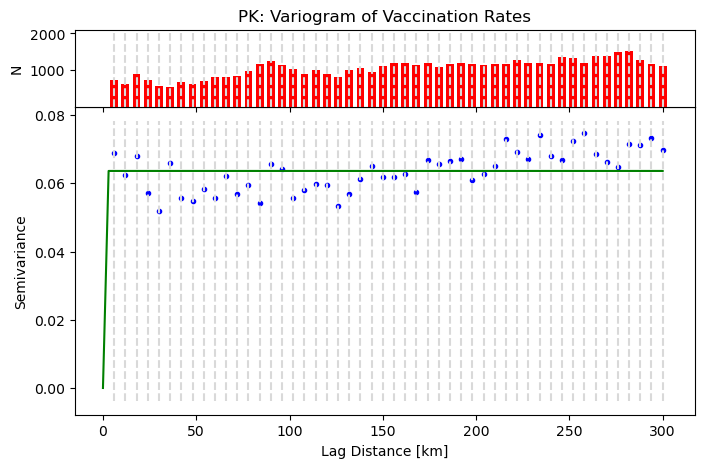

<Figure size 640x480 with 0 Axes>

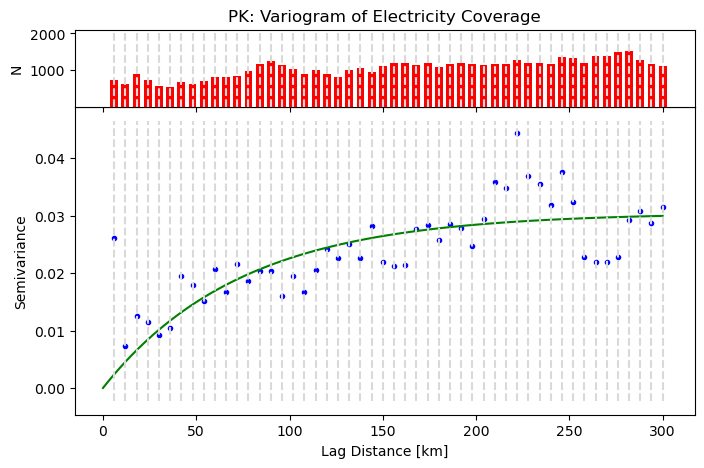

Skipping plot for PK: Variogram of Fresh Water Access, no valid data.


<Figure size 640x480 with 0 Axes>

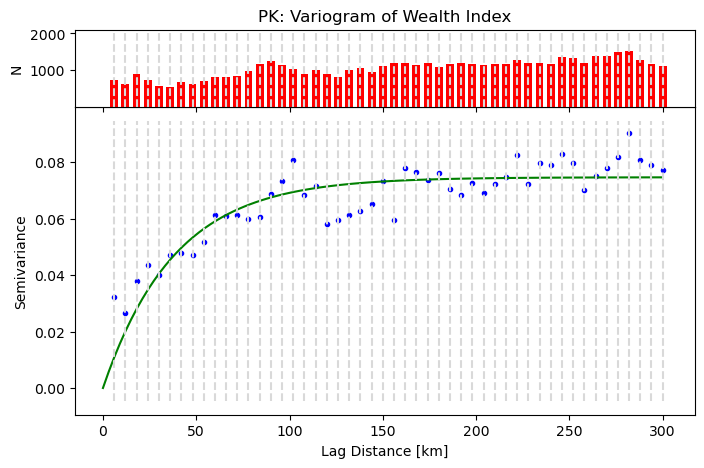

<Figure size 640x480 with 0 Axes>

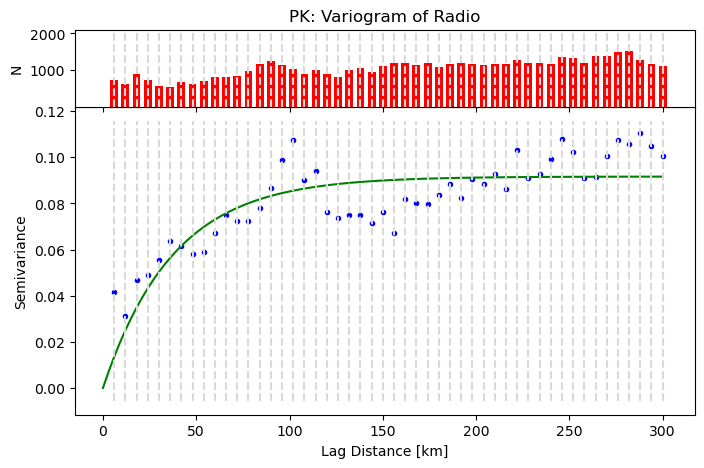

<Figure size 640x480 with 0 Axes>

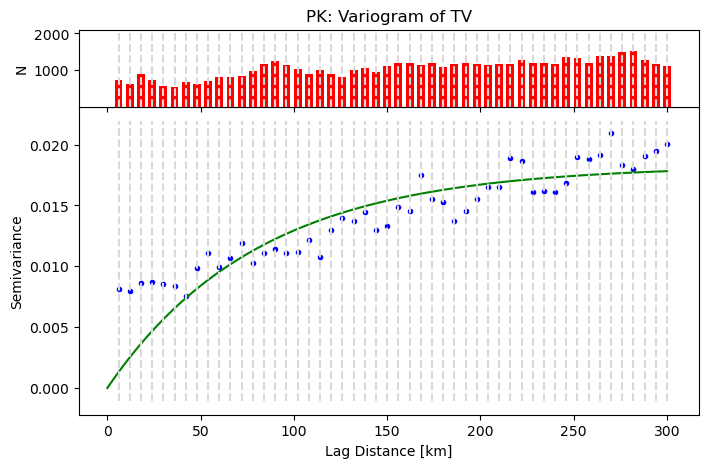

In [238]:
out_dir=results_config.PLOT_VARIOGRAM_DIR

plot_variograms(country_code, 
                geospatial_df, 
                aoi_configurations, 
                out_dir=out_dir,
                normalize=False, 
                variogram_model='Exponential',
                n_lags=50,
                max_lag_km=300)